In [1]:
import keras
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras import backend as K
from keras.utils import Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
from glob import glob
import datetime
import os

imgPath = "/mnt/ml/NOAA/color"
imgCropPath = "/mnt/ml/NOAA/crop"
irPath = "/mnt/ml/NOAA/thermal"
dataPath = "/mnt/ml/NOAA/arcticseals/data"
modelPath = "/mnt/ml/NOAA/models/vgg16"

Using TensorFlow backend.


### Metaparameters

In [2]:
NB_EPOCH1 = 10
NB_EPOCH2 = 50
BATCH_SIZE = 16
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LR = [0.1, 0.01, 0.001, 0.0001]
# Crop center

### Data generator

In [3]:
classes = {'Anomaly': 0, 'Animal': 1}

In [4]:
def GetPartitionsAndLabels():
    df = pd.read_csv("{}/training.csv".format(dataPath))
    rowcount = int(df.shape[0])
    train_count = int(rowcount * (1 - VALIDATION_SPLIT))
    test_count = rowcount - train_count
    print ("Train: {} Validation: {}".format(train_count, test_count))
    
    ids = df["hotspot_id"].astype(str).values
   
    train = ids[:train_count]
    validation = ids[train_count:]
    
    print(train.shape)
    print(validation.shape)
    
    partitions = {}
    partitions['train'] = train
    partitions['validation'] = validation

    labels = {}
    for index, row in df.iterrows():
        label = row.hotspot_type
        labels[str(row.hotspot_id)] = classes[label]
    
    return partitions, labels

partition, labels = GetPartitionsAndLabels()

Train: 5299 Validation: 1325
(5299,)
(1325,)


(224, 224, 3)
1


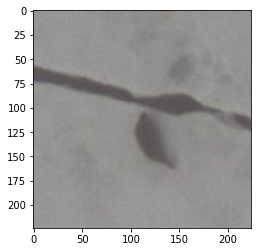

(224, 224, 3)
1


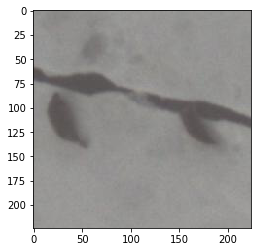

(224, 224, 3)
0


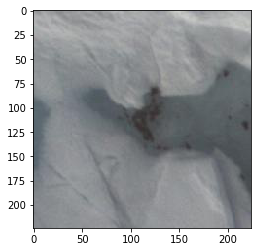

(224, 224, 3)
1


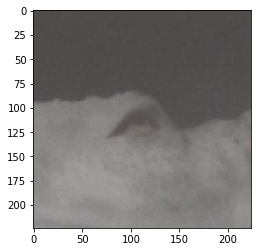

(224, 224, 3)
0


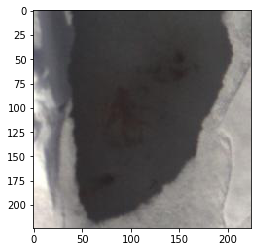

In [5]:
def LoadImage(id):

    # Images are named <originalName>_HOTSPOT_ID.JPG
    # ID can be "1234" which Pandas converts to "1234.0" or "1234.99"
    if (id.endswith('.0')):
        id = id[:-2]

    imageMask = "{}/*HOTSPOT_{}.JPG".format(imgCropPath, id)
    imageFiles = glob(imageMask)
    assert len(imageFiles) == 1
    
    imageFile = imageFiles[0]
    image = Image.open(imageFile)
    
    # 1. Downsampling to adjust for VGG16 dimension
    # image.thumbnail((224, 224), Image.ANTIALIAS)
    
    # 2. Crop centers to adjust for VGG16 dimension
    subimage = image.crop((144, 144, 368, 368))
    return np.array(subimage)   


for i in range(-5, 0, 1):
    img = LoadImage(partition['train'][i])
    print(img.shape)
    imshow(img)
    print(labels[partition['train'][i]])
    plt.show()

In [6]:
# From https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = LoadImage(ID)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

### VGG16 model layout:

In [7]:
def ShowLayers(base_model):
    for i, layer in enumerate(base_model.layers):
        activation = ""
        try:
            activation = layer.activation
        except AttributeError:
            pass
            
        print (i, layer.name, layer.output_shape, activation)

In [8]:
original_model = VGG16(weights=None, include_top=True)
ShowLayers(original_model)

0 input_1 (None, 224, 224, 3) 
1 block1_conv1 (None, 224, 224, 64) <function relu at 0x7ff8bf58f6a8>
2 block1_conv2 (None, 224, 224, 64) <function relu at 0x7ff8bf58f6a8>
3 block1_pool (None, 112, 112, 64) 
4 block2_conv1 (None, 112, 112, 128) <function relu at 0x7ff8bf58f6a8>
5 block2_conv2 (None, 112, 112, 128) <function relu at 0x7ff8bf58f6a8>
6 block2_pool (None, 56, 56, 128) 
7 block3_conv1 (None, 56, 56, 256) <function relu at 0x7ff8bf58f6a8>
8 block3_conv2 (None, 56, 56, 256) <function relu at 0x7ff8bf58f6a8>
9 block3_conv3 (None, 56, 56, 256) <function relu at 0x7ff8bf58f6a8>
10 block3_pool (None, 28, 28, 256) 
11 block4_conv1 (None, 28, 28, 512) <function relu at 0x7ff8bf58f6a8>
12 block4_conv2 (None, 28, 28, 512) <function relu at 0x7ff8bf58f6a8>
13 block4_conv3 (None, 28, 28, 512) <function relu at 0x7ff8bf58f6a8>
14 block4_pool (None, 14, 14, 512) 
15 block5_conv1 (None, 14, 14, 512) <function relu at 0x7ff8bf58f6a8>
16 block5_conv2 (None, 14, 14, 512) <function relu at 0x7

Removing top and last 3 layers:

In [9]:
# Input = 512x512x3

# VGG16 size : 224x224x3
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Will download the 560MB trained model.

# Output = ['Anomaly' 'Bearded Seal' 'Ringed Seal' 'Polar Bear' 'UNK Seal']
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc1', activation='relu')(x)
x = Dense(4096, name='fc2', activation='relu')(x)
predictions = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)
ShowLayers(model)

0 input_2 (None, 224, 224, 3) 
1 block1_conv1 (None, 224, 224, 64) <function relu at 0x7ff8bf58f6a8>
2 block1_conv2 (None, 224, 224, 64) <function relu at 0x7ff8bf58f6a8>
3 block1_pool (None, 112, 112, 64) 
4 block2_conv1 (None, 112, 112, 128) <function relu at 0x7ff8bf58f6a8>
5 block2_conv2 (None, 112, 112, 128) <function relu at 0x7ff8bf58f6a8>
6 block2_pool (None, 56, 56, 128) 
7 block3_conv1 (None, 56, 56, 256) <function relu at 0x7ff8bf58f6a8>
8 block3_conv2 (None, 56, 56, 256) <function relu at 0x7ff8bf58f6a8>
9 block3_conv3 (None, 56, 56, 256) <function relu at 0x7ff8bf58f6a8>
10 block3_pool (None, 28, 28, 256) 
11 block4_conv1 (None, 28, 28, 512) <function relu at 0x7ff8bf58f6a8>
12 block4_conv2 (None, 28, 28, 512) <function relu at 0x7ff8bf58f6a8>
13 block4_conv3 (None, 28, 28, 512) <function relu at 0x7ff8bf58f6a8>
14 block4_pool (None, 14, 14, 512) 
15 block5_conv1 (None, 14, 14, 512) <function relu at 0x7ff8bf58f6a8>
16 block5_conv2 (None, 14, 14, 512) <function relu at 0x7

### Freeze VGG original layers

In [10]:
for layer in base_model.layers: layer.trainable = False

#### Train the top layers

In [11]:
def ShowGraphs(history):
    if (VERBOSE==1):
        # list all data in history
        print(history.history.keys())

        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    

Epoch 1/10
331/331 [==============================] - 60s 181ms/step - loss: 8.5061 - acc: 0.4713 - categorical_accuracy: 0.4713 - val_loss: 2.1253 - val_acc: 0.8681 - val_categorical_accuracy: 0.8681
Epoch 2/10
331/331 [==============================] - 52s 158ms/step - loss: 8.5064 - acc: 0.4722 - categorical_accuracy: 0.4722 - val_loss: 2.1499 - val_acc: 0.8666 - val_categorical_accuracy: 0.8666
Epoch 3/10
331/331 [==============================] - 51s 154ms/step - loss: 8.5064 - acc: 0.4722 - categorical_accuracy: 0.4722 - val_loss: 2.1376 - val_acc: 0.8674 - val_categorical_accuracy: 0.8674
Epoch 4/10
331/331 [==============================] - 54s 163ms/step - loss: 8.5095 - acc: 0.4721 - categorical_accuracy: 0.4721 - val_loss: 2.1376 - val_acc: 0.8674 - val_categorical_accuracy: 0.8674
Epoch 5/10
331/331 [==============================] - 52s 158ms/step - loss: 8.5064 - acc: 0.4722 - categorical_accuracy: 0.4722 - val_loss: 2.1622 - val_acc: 0.8659 - val_categorical_accuracy: 0.

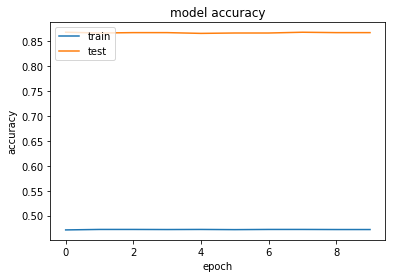

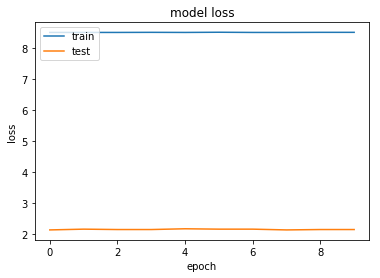

In [17]:
#optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=0.1)
# TODO Adam
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
#model.summary()

params = {'dim': (224,224),
          'n_channels': 3,
          'batch_size': BATCH_SIZE,
          'n_classes': len(classes),
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Checpointing
checkpoint = ModelCheckpoint(filepath=os.path.join(modelPath, "model-{epoch:02d}.h5"))

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4,
                    epochs=NB_EPOCH1,
                    callbacks=[checkpoint])

ShowGraphs(history)

Epoch 1/10
331/331 [==============================] - 59s 177ms/step - loss: 8.4882 - acc: 0.4724 - categorical_accuracy: 0.4724 - val_loss: 2.1622 - val_acc: 0.8659 - val_categorical_accuracy: 0.8659
Epoch 2/10
331/331 [==============================] - 52s 156ms/step - loss: 8.5064 - acc: 0.4722 - categorical_accuracy: 0.4722 - val_loss: 2.1622 - val_acc: 0.8659 - val_categorical_accuracy: 0.8659
Epoch 3/10
331/331 [==============================] - 53s 159ms/step - loss: 8.5095 - acc: 0.4721 - categorical_accuracy: 0.4721 - val_loss: 2.1622 - val_acc: 0.8659 - val_categorical_accuracy: 0.8659
Epoch 4/10
331/331 [==============================] - 52s 156ms/step - loss: 8.5125 - acc: 0.4719 - categorical_accuracy: 0.4719 - val_loss: 2.1622 - val_acc: 0.8659 - val_categorical_accuracy: 0.8659
Epoch 5/10
331/331 [==============================] - 52s 156ms/step - loss: 8.5125 - acc: 0.4719 - categorical_accuracy: 0.4719 - val_loss: 2.1622 - val_acc: 0.8659 - val_categorical_accuracy: 0.

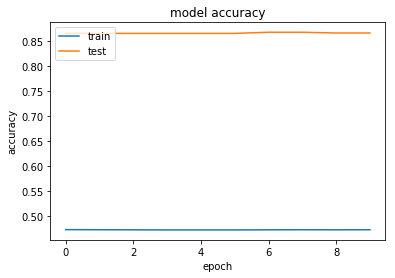

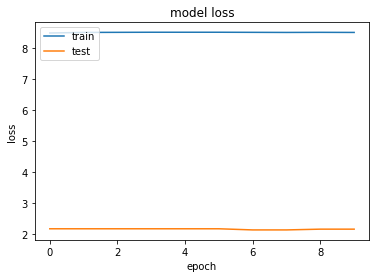

In [12]:
#optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=0.01)
# TODO Adam
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
#model.summary()

params = {'dim': (224,224),
          'n_channels': 3,
          'batch_size': BATCH_SIZE,
          'n_classes': len(classes),
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Checpointing
checkpoint = ModelCheckpoint(filepath=os.path.join(modelPath, "model-{epoch:02d}.h5"))

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4,
                    epochs=NB_EPOCH1,
                    callbacks=[checkpoint])

ShowGraphs(history)

Epoch 1/10
331/331 [==============================] - 61s 185ms/step - loss: 7.6017 - acc: 0.5276 - categorical_accuracy: 0.5276 - val_loss: 13.9805 - val_acc: 0.1326 - val_categorical_accuracy: 0.1326
Epoch 2/10
331/331 [==============================] - 57s 173ms/step - loss: 7.6056 - acc: 0.5281 - categorical_accuracy: 0.5281 - val_loss: 13.9928 - val_acc: 0.1319 - val_categorical_accuracy: 0.1319
Epoch 3/10
331/331 [==============================] - 57s 171ms/step - loss: 7.6086 - acc: 0.5279 - categorical_accuracy: 0.5279 - val_loss: 13.9928 - val_acc: 0.1319 - val_categorical_accuracy: 0.1319
Epoch 4/10
331/331 [==============================] - 57s 172ms/step - loss: 7.6117 - acc: 0.5278 - categorical_accuracy: 0.5278 - val_loss: 14.0051 - val_acc: 0.1311 - val_categorical_accuracy: 0.1311
Epoch 5/10
331/331 [==============================] - 57s 173ms/step - loss: 7.6117 - acc: 0.5278 - categorical_accuracy: 0.5278 - val_loss: 14.0051 - val_acc: 0.1311 - val_categorical_accurac

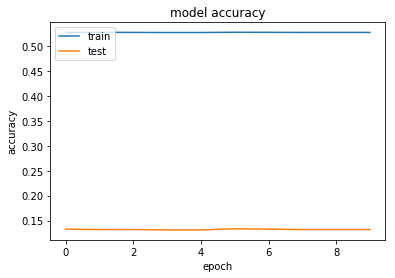

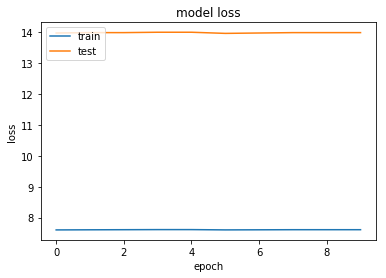

In [12]:
#optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=0.001)
# TODO Adam
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
#model.summary()

params = {'dim': (224,224),
          'n_channels': 3,
          'batch_size': BATCH_SIZE,
          'n_classes': len(classes),
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Checpointing
checkpoint = ModelCheckpoint(filepath=os.path.join(modelPath, "model-{epoch:02d}.h5"))

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4,
                    epochs=NB_EPOCH1,
                    callbacks=[checkpoint])

ShowGraphs(history)

Epoch 1/10
331/331 [==============================] - 61s 184ms/step - loss: 2.9220 - acc: 0.8012 - categorical_accuracy: 0.8012 - val_loss: 1.0636 - val_acc: 0.9314 - val_categorical_accuracy: 0.9314
Epoch 2/10
331/331 [==============================] - 55s 166ms/step - loss: 3.1054 - acc: 0.8036 - categorical_accuracy: 0.8036 - val_loss: 7.8709 - val_acc: 0.5069 - val_categorical_accuracy: 0.5069
Epoch 3/10
331/331 [==============================] - 55s 166ms/step - loss: 2.2090 - acc: 0.8623 - categorical_accuracy: 0.8623 - val_loss: 1.1956 - val_acc: 0.9245 - val_categorical_accuracy: 0.9245
Epoch 6/10
331/331 [==============================] - 55s 166ms/step - loss: 2.4991 - acc: 0.8438 - categorical_accuracy: 0.8438 - val_loss: 1.6199 - val_acc: 0.8994 - val_categorical_accuracy: 0.8994
Epoch 7/10
331/331 [==============================] - 55s 166ms/step - loss: 2.4026 - acc: 0.8499 - categorical_accuracy: 0.8499 - val_loss: 2.9062 - val_acc: 0.8186 - val_categorical_accuracy: 0.

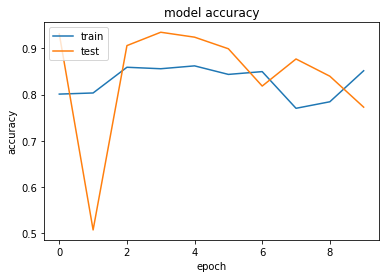

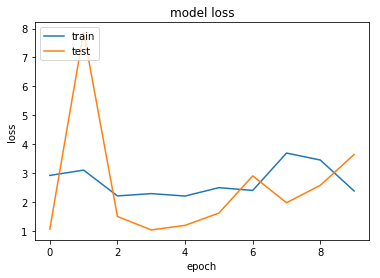

In [12]:
#optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=0.0001)
# TODO Adam
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
#model.summary()

params = {'dim': (224,224),
          'n_channels': 3,
          'batch_size': BATCH_SIZE,
          'n_classes': len(classes),
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Checpointing
checkpoint = ModelCheckpoint(filepath=os.path.join(modelPath, "model-{epoch:02d}.h5"))

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4,
                    epochs=NB_EPOCH1,
                    callbacks=[checkpoint])

ShowGraphs(history)

### Fine tune-optimization: unfreze part of the layer - ignore if top doesn't work

In [40]:
FREEZELAYERS = int(len(model.layers) / 2)
print ("We have {} layers. Freeze first {} layers".format(len(model.layers), FREEZELAYERS))


for layer in model.layers[:FREEZELAYERS]: layer.trainable = False
for layer in model.layers[FREEZELAYERS:]: layer.trainable = True

We have 23 layers. Freeze first 11 layers


In [14]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

In [ ]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4,
                    epochs=NB_EPOCH2,
                    callbacks=[checkpoint])

Epoch 1/50
331/331 [==============================] - 54s 164ms/step - loss: 2.3987 - acc: 0.8505 - categorical_accuracy: 0.8505 - val_loss: 1.4670 - val_acc: 0.9085 - val_categorical_accuracy: 0.9085
Epoch 2/50
331/331 [==============================] - 52s 157ms/step - loss: 2.1736 - acc: 0.8646 - categorical_accuracy: 0.8646 - val_loss: 1.8217 - val_acc: 0.8864 - val_categorical_accuracy: 0.8864
Epoch 3/50
331/331 [==============================] - 52s 157ms/step - loss: 2.5081 - acc: 0.8442 - categorical_accuracy: 0.8442 - val_loss: 2.2580 - val_acc: 0.8598 - val_categorical_accuracy: 0.8598
Epoch 6/50
331/331 [==============================] - 52s 157ms/step - loss: 2.6859 - acc: 0.8331 - categorical_accuracy: 0.8331 - val_loss: 1.3145 - val_acc: 0.9184 - val_categorical_accuracy: 0.9184
Epoch 7/50
331/331 [==============================] - 52s 157ms/step - loss: 3.5213 - acc: 0.7815 - categorical_accuracy: 0.7815 - val_loss: 1.2777 - val_acc: 0.9207 - val_categorical_accuracy: 0.

dict_keys(['val_acc', 'categorical_accuracy', 'acc', 'val_loss', 'val_categorical_accuracy', 'loss'])


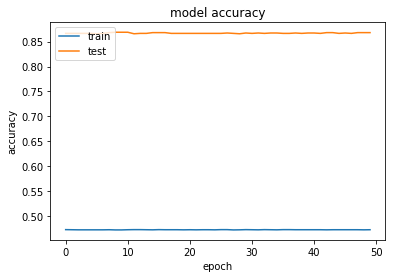

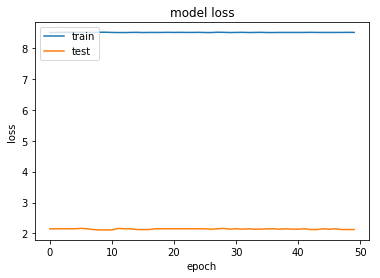

In [ ]:
ShowGraphs(history)

In [45]:
fileName = "{}/{}-final.h5".format(modelPath, datetime.datetime.today().strftime('%Y-%m-%d'))
print ("Saving model to {}".format(fileName))
model.save(fileName)

Saving model to /mnt/ml/NOAA/models/vgg16/2018-07-24-final.h5
